# Libraries import

In [2]:
# %pip install "datasets" "scikit-learn" "torchmetrics>=0.7" "scipy" "pytorch-lightning>=1.4" "transformers" "torchtext>=0.9" "setuptools==59.5.0" "ipython[notebook]" "torch>=1.8" "seaborn"

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%cd LiU/732A81 - Text Mining project
%pwd

# Import all libraries
import pandas as pd
import numpy as np
import re

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

#handling html data
from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

/workspace/LiU/732A81 - Text Mining project


# Load data

In [2]:
from datasets import load_dataset
dataset = load_dataset('eurlex')
#eurovoc_concepts_df = pd.read_json('./data/datasets/EURLEX57K/eurovoc_concepts.jsonl', lines=True)

train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])
val = pd.DataFrame(dataset['validation'])
#cumulative = pd.concat([train, test, val])

No config specified, defaulting to: eurlex/eurlex57k
Found cached dataset eurlex (/root/.cache/huggingface/datasets/eurlex/eurlex57k/1.1.0/d2fdeaa4fcb5f41394d2ed0317c8541d7f9be85d2d601b9fa586c8b461bc3a34)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
# Load the data from disk
import pickle
with open('./data/preprocessed_title/x_train.pkl', 'rb') as f:
    x_train = pickle.load(f)
with open('./data/preprocessed_title/x_test.pkl', 'rb') as f:
    x_test = pickle.load(f)
with open('./data/preprocessed_title/x_val.pkl', 'rb') as f:
    x_val = pickle.load(f)
with open('./data/preprocessed_title/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('./data/preprocessed_title/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
with open('./data/preprocessed_title/y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)
with open('./data/preprocessed_title/y.pkl', 'rb') as f:
    y = pickle.load(f)
with open('./data/preprocessed_title/eurovoc_concepts_df.pkl', 'rb') as f:
    eurovoc_concepts_df = pickle.load(f)
with open('./data/preprocessed_title/cumulative.pkl', 'rb') as f:
    cumulative = pickle.load(f)

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(cumulative['eurovoc_concepts_limited'])

# Pre-process the data

Commented out for safety since it takes a long time to run. It's advised to load from disk.

In [8]:
# import spacy
# nlp = spacy.load('en_core_web_lg', exclude=['parser', 'ner'])

# def preprocess(text):
#     # TODO: Replace the next line with your own code.
#     doc = nlp(text)
#     data = [(token.lemma_) for token in doc if token.is_alpha and not token.is_stop and token.lemma_.isalpha()]
#     data = pd.DataFrame(data, columns=['lemma'])
#     return list(data.lemma)

In [9]:
# train.head()

# train['preprocessed'] = train['title'].apply(preprocess)
# test['preprocessed'] = test['title'].apply(preprocess)
# val['preprocessed'] = val['title'].apply(preprocess)
# cumulative = pd.concat([train, test, val])

,celex_id,title,text,eurovoc_concepts
0,32014R0727,Commission Implementing Regulation (EU) No 727...,1.7.2014 EN Official Journal of the European U...,"[1402, 2771, 3191, 5055, 519, 5969, 5971]"
1,31975R2481,Regulation (EEC) No 2481/75 of the Council of ...,REGULATION (EEC) No 2481/75 OF THE COUNCIL of...,"[2319, 2713, 2938, 693]"
2,32010D0008,"2010/8/EU, Euratom: Commission Decision of 22 ...",7.1.2010 EN Official Journal of the European U...,"[3560, 365, 4256, 4261, 4353, 4585]"
3,31982D0211,82/211/EEC: Commission Decision of 17 March 19...,COMMISSION DECISION\nof 17 March 1982\nestabl...,"[1091, 3842, 3874, 4110, 4381, 5287]"
4,31996D0084,"96/84/Euratom, ECSC, EC: Commission Decision o...",COMMISSION DECISION of 8 January 1996 adjustin...,"[1026, 1048, 2300, 3653, 4271, 4390]"


In [10]:
# train.head()

,celex_id,title,text,eurovoc_concepts,preprocessed
0,32014R0727,Commission Implementing Regulation (EU) No 727...,1.7.2014 EN Official Journal of the European U...,"[1402, 2771, 3191, 5055, 519, 5969, 5971]","[Commission, Implementing, Regulation, EU, Jun..."
1,31975R2481,Regulation (EEC) No 2481/75 of the Council of ...,REGULATION (EEC) No 2481/75 OF THE COUNCIL of...,"[2319, 2713, 2938, 693]","[regulation, EEC, Council, September, amend, R..."
2,32010D0008,"2010/8/EU, Euratom: Commission Decision of 22 ...",7.1.2010 EN Official Journal of the European U...,"[3560, 365, 4256, 4261, 4353, 4585]","[EU, Euratom, Commission, Decision, December, ..."
3,31982D0211,82/211/EEC: Commission Decision of 17 March 19...,COMMISSION DECISION\nof 17 March 1982\nestabl...,"[1091, 3842, 3874, 4110, 4381, 5287]","[EEC, Commission, Decision, March, establish, ..."
4,31996D0084,"96/84/Euratom, ECSC, EC: Commission Decision o...",COMMISSION DECISION of 8 January 1996 adjustin...,"[1026, 1048, 2300, 3653, 4271, 4390]","[Euratom, ECSC, EC, Commission, Decision, Janu..."


In [11]:
# labels_count = cumulative.explode('eurovoc_concepts').groupby('eurovoc_concepts').count().reset_index()
# labels_count = labels_count[['eurovoc_concepts', 'text']]
# labels_count.columns = ['eurovoc_concepts', 'count']
# labels_count.head(10)

,eurovoc_concepts,count
0,10,7
1,1000,34
2,1002,2
3,1004,4
4,1005,979
5,1006,23
6,1007,8
7,1008,27
8,1010,5
9,1011,3


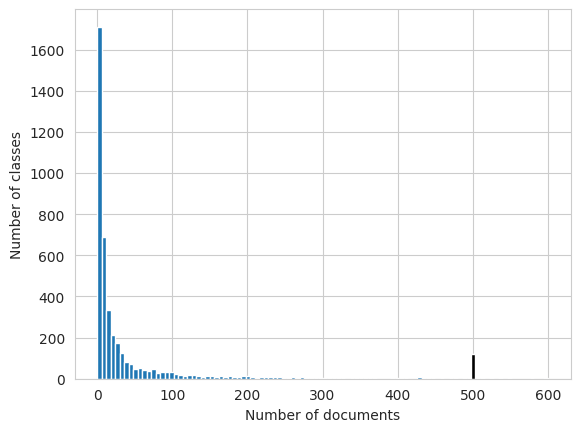

In [12]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("whitegrid")

# # plot histogram of the number of documents per class
# plt.hist(labels_count['count'], bins=100, range=(0, 600))
# plt.xlabel('Number of documents')
# plt.ylabel('Number of classes')
# plt.bar(500, labels_count[labels_count['count'] >= 500].count(), color='black', width=5)
# plt.show();

In [13]:
# # Number of classes with less than 10 documents
# print(f'Number of classes with less than 10 documents: {labels_count[labels_count["count"] < 10].count().values[0]}')

# # Number of classes with less than 50 documents
# print(f'Number of classes with less than 50 documents: {labels_count[labels_count["count"] < 50].count().values[0]}')


Number of classes with less than 10 documents: 2222
Number of classes with less than 50 documents: 3423


Keep only labels that have more than 10 documents

In [14]:
# labels_count = labels_count[labels_count['count'] >= 10].reset_index(drop=True)

# eurovoc_concepts_df = eurovoc_concepts_df[eurovoc_concepts_df['id'].isin(labels_count['eurovoc_concepts'])].sort_values(by='id').reset_index(drop=True)

In [15]:
# # Remove classes with less than 10 documents from the dataset and keep the ones left

# train['eurovoc_concepts_limited'] = train['eurovoc_concepts'].apply(lambda x: [i for i in x if i in labels_count['eurovoc_concepts'].values])
# train = train[train['eurovoc_concepts_limited'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
# test['eurovoc_concepts_limited'] = test['eurovoc_concepts'].apply(lambda x: [i for i in x if i in labels_count['eurovoc_concepts'].values])
# test = test[test['eurovoc_concepts_limited'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
# val['eurovoc_concepts_limited'] = val['eurovoc_concepts'].apply(lambda x: [i for i in x if i in labels_count['eurovoc_concepts'].values])
# val = val[val['eurovoc_concepts_limited'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
# cumulative = pd.concat([train, test, val], keys=['train', 'test', 'val'])

In [16]:
# cumulative.head()

celex_id                                              title  \
train 0  32014R0727  Commission Implementing Regulation (EU) No 727...   
      1  31975R2481  Regulation (EEC) No 2481/75 of the Council of ...   
      2  32010D0008  2010/8/EU, Euratom: Commission Decision of 22 ...   
      3  31982D0211  82/211/EEC: Commission Decision of 17 March 19...   
      4  31996D0084  96/84/Euratom, ECSC, EC: Commission Decision o...   

                                                      text  \
train 0  1.7.2014 EN Official Journal of the European U...   
      1  REGULATION (EEC) No 2481/75 OF THE COUNCIL  of...   
      2  7.1.2010 EN Official Journal of the European U...   
      3  COMMISSION  DECISION\nof 17 March 1982\nestabl...   
      4  COMMISSION DECISION of 8 January 1996 adjustin...   

                                  eurovoc_concepts  \
train 0  [1402, 2771, 3191, 5055, 519, 5969, 5971]   
      1                    [2319, 2713, 2938, 693]   
      2        [3560, 365, 4256, 4261, 4353, 4585]   
      3       [1091, 3842, 3874, 4110, 4381, 5287]   
      4       [1026, 1048, 2300, 3653, 4271, 4390]   

                                              preprocessed  \
train 0  [Commission, Implementing, Regulation, EU, Jun...   
      1  [regulation, EEC, Council, September, amend, R...   
      2  [EU, Euratom, Commission, Decision, December, ...   
      3  [EEC, Commission, Decision, March, establish, ...   
      4  [Euratom, ECSC, EC, Commission, Decision, Janu...   

                     eurovoc_concepts_limited  
train 0         [2771, 3191, 5055, 519, 5969]  
      1               [2319, 2713, 2938, 693]  
      2   [3560, 365, 4256, 4261, 4353, 4585]  
      3        [1091, 3842, 3874, 4381, 5287]  
      4  [1026, 1048, 2300, 3653, 4271, 4390]

Binarize the labels

In [17]:
# from sklearn.preprocessing import MultiLabelBinarizer

# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(cumulative['eurovoc_concepts_limited'])
# y.shape

(56979, 2049)

In [18]:
# x_train = cumulative.loc['train', 'preprocessed'].reset_index(drop=True)
# x_test = cumulative.loc['test', 'preprocessed'].reset_index(drop=True)
# x_val = cumulative.loc['val', 'preprocessed'].reset_index(drop=True)

# y_train = y[:len(x_train)].copy()
# y_test = y[len(x_train):len(x_train)+len(x_test)].copy()
# y_val = y[len(x_train)+len(x_test):].copy()


In [20]:
# # Save the data to disk for later use
# import pickle
# with open('./data/preprocessed_title/x_train.pkl', 'wb') as f:
#     pickle.dump(x_train, f)
# with open('./data/preprocessed_title/x_test.pkl', 'wb') as f:
#     pickle.dump(x_test, f)
# with open('./data/preprocessed_title/x_val.pkl', 'wb') as f:
#     pickle.dump(x_val, f)
# with open('./data/preprocessed_title/y_train.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# with open('./data/preprocessed_title/y_test.pkl', 'wb') as f:
#     pickle.dump(y_test, f)
# with open('./data/preprocessed_title/y_val.pkl', 'wb') as f:
#     pickle.dump(y_val, f)
# with open('./data/preprocessed_title/y.pkl', 'wb') as f:
#     pickle.dump(y, f)
# with open('./data/preprocessed_title/eurovoc_concepts_df.pkl', 'wb') as f:
#     pickle.dump(eurovoc_concepts_df, f)
# with open('./data/preprocessed_title/cumulative.pkl', 'wb') as f:
#     pickle.dump(cumulative, f)




# Dataset and dataloader

In [3]:
class QTagDataset(Dataset):
    def __init__(self,quest,tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.labels = tags
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
            
        }

In [4]:
class QTagDataModule(pl.LightningDataModule):
    
    def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,batch_size=16,max_token_len=200):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, **kwargs):
        self.train_dataset = QTagDataset(quest=self.tr_text, tags=self.tr_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.val_dataset  = QTagDataset(quest=self.val_text,tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset  = QTagDataset(quest=self.test_text,tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
        
    def train_dataloader(self):
        return DataLoader (self.train_dataset,batch_size = self.batch_size,shuffle = True , num_workers=8, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader (self.val_dataset,batch_size= 16, num_workers=8, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader (self.test_dataset,batch_size= 16, num_workers=8, persistent_workers=True)

In [5]:
# Initialize the Bert tokenizer
BERT_MODEL_NAME = "nlpaueb/legal-bert-base-uncased" # we will use the BERT base model(the smaller one)
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [6]:
max_word_cnt = 512
quest_cnt = 0

# For every sentence...
for question in cumulative['preprocessed']:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = Bert_tokenizer.encode(question, add_special_tokens=True)

    # Update the maximum sentence length.
    if len(input_ids) > max_word_cnt:
        quest_cnt +=1

print(f'# Question having word count > {max_word_cnt}: is  {quest_cnt} out of {len(cumulative)}')

# Question having word count > 512: is  0 out of 56979


In [7]:
# Initialize the parameters that will be use for training
N_EPOCHS = 300
BATCH_SIZE = 16
MAX_LEN = 300
LR = 2e-05

In [8]:
# Instantiate and set up the data_module
QTdata_module = QTagDataModule(x_train,y_train,x_val,y_val,x_test,y_test,Bert_tokenizer,BATCH_SIZE,MAX_LEN)
QTdata_module.setup()

# Model Training

In [9]:
class QTagClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self, n_classes=10, steps_per_epoch=None, n_epochs=3, lr=2e-5 ):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes) # outputs = number of labels
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self,input_ids, attn_mask):
        output = self.bert(input_ids = input_ids ,attention_mask = attn_mask)
        output = self.classifier(output.pooler_output)
                
        return output
    
    
    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }


    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters() , lr=self.lr)
        warmup_steps = self.steps_per_epoch//3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)

        return [optimizer], [scheduler]

In [10]:
# Instantiate the classifier model
steps_per_epoch = len(x_train)//BATCH_SIZE
model = QTagClassifier(n_classes=y.shape[1], steps_per_epoch=steps_per_epoch,n_epochs=N_EPOCHS,lr=LR)

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
#Initialize Pytorch Lightning callback for Model checkpointing

# saves a file like: input/QTag-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    dirpath='legalbert_model_with_titles',
    monitor='val_loss',# monitored quantity
    filename='Legal_titles-{epoch:02d}-{val_loss:.5f}',
    save_top_k=3, #  save the top 3 models
    mode='min', # mode of the monitored quantity  for optimization
    save_last=True, # save the last model
    verbose=True
)

# Initialize Pytorch Lightning callback for Early Stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=5,
    verbose=True,
    mode='min'
)

# Model logger
logger = TensorBoardLogger('lightning_logs', name='LegalBert_titles')


In [12]:
# Instantiate the Model Trainer
trainer = pl.Trainer(max_epochs = N_EPOCHS ,accelerator='auto', devices=[0], callbacks=[checkpoint_callback, early_stop_callback], enable_progress_bar=True, precision=16, amp_backend="native", logger=logger)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
!nvidia-smi

Sun Jan  8 19:07:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   53C    P0    35W / 220W |    130MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:06:00.0 Off |                  N/A |
| 82%   

In [15]:
# Train the Classifier Model
trainer.fit(model, QTdata_module)

Missing logger folder: lightning_logs/LegalBert_titles
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 109 M 
1 | classifier | Linear            | 1.6 M 
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
111 M     Trainable params
0         Non-trainable params
111 M     Total params
222.116   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.714
Epoch 0, global step 2812: 'val_loss' reached 0.71415 (best 0.71415), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=00-val_loss=0.71415.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.691
Epoch 1, global step 5624: 'val_loss' reached 0.69063 (best 0.69063), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=01-val_loss=0.69063.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.652
Epoch 2, global step 8436: 'val_loss' reached 0.65187 (best 0.65187), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=02-val_loss=0.65187.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.595
Epoch 3, global step 11248: 'val_loss' reached 0.59466 (best 0.59466), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=03-val_loss=0.59466.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.524
Epoch 4, global step 14060: 'val_loss' reached 0.52432 (best 0.52432), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=04-val_loss=0.52432.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 0.445
Epoch 5, global step 16872: 'val_loss' reached 0.44470 (best 0.44470), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=05-val_loss=0.44470.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 0.362
Epoch 6, global step 19684: 'val_loss' reached 0.36238 (best 0.36238), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=06-val_loss=0.36238.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 0.283
Epoch 7, global step 22496: 'val_loss' reached 0.28286 (best 0.28286), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=07-val_loss=0.28286.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 0.212
Epoch 8, global step 25308: 'val_loss' reached 0.21160 (best 0.21160), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=08-val_loss=0.21160.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 0.152
Epoch 9, global step 28120: 'val_loss' reached 0.15232 (best 0.15232), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=09-val_loss=0.15232.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.106
Epoch 10, global step 30932: 'val_loss' reached 0.10638 (best 0.10638), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=10-val_loss=0.10638.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.073
Epoch 11, global step 33744: 'val_loss' reached 0.07296 (best 0.07296), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=11-val_loss=0.07296.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.050
Epoch 12, global step 36556: 'val_loss' reached 0.05003 (best 0.05003), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=12-val_loss=0.05003.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.035
Epoch 13, global step 39368: 'val_loss' reached 0.03512 (best 0.03512), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=13-val_loss=0.03512.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.026
Epoch 14, global step 42180: 'val_loss' reached 0.02593 (best 0.02593), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=14-val_loss=0.02593.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.021
Epoch 15, global step 44992: 'val_loss' reached 0.02056 (best 0.02056), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=15-val_loss=0.02056.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.018
Epoch 16, global step 47804: 'val_loss' reached 0.01758 (best 0.01758), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=16-val_loss=0.01758.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.016
Epoch 17, global step 50616: 'val_loss' reached 0.01600 (best 0.01600), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=17-val_loss=0.01600.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.015
Epoch 18, global step 53428: 'val_loss' reached 0.01517 (best 0.01517), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=18-val_loss=0.01517.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.015
Epoch 19, global step 56240: 'val_loss' reached 0.01474 (best 0.01474), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=19-val_loss=0.01474.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 20, global step 59052: 'val_loss' reached 0.01450 (best 0.01450), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=20-val_loss=0.01450.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 21, global step 61864: 'val_loss' reached 0.01435 (best 0.01435), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=21-val_loss=0.01435.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 22, global step 64676: 'val_loss' reached 0.01426 (best 0.01426), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=22-val_loss=0.01426.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 23, global step 67488: 'val_loss' reached 0.01420 (best 0.01420), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=23-val_loss=0.01420.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 24, global step 70300: 'val_loss' reached 0.01416 (best 0.01416), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=24-val_loss=0.01416.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 25, global step 73112: 'val_loss' reached 0.01414 (best 0.01414), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=25-val_loss=0.01414.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 26, global step 75924: 'val_loss' reached 0.01412 (best 0.01412), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=26-val_loss=0.01412.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 27, global step 78736: 'val_loss' reached 0.01410 (best 0.01410), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=27-val_loss=0.01410.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 28, global step 81548: 'val_loss' reached 0.01410 (best 0.01410), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=28-val_loss=0.01410.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 29, global step 84360: 'val_loss' reached 0.01409 (best 0.01409), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=29-val_loss=0.01409.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 30, global step 87172: 'val_loss' reached 0.01408 (best 0.01408), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=30-val_loss=0.01408.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 31, global step 89984: 'val_loss' reached 0.01408 (best 0.01408), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=31-val_loss=0.01408.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 32, global step 92796: 'val_loss' reached 0.01408 (best 0.01408), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=32-val_loss=0.01408.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 33, global step 95608: 'val_loss' reached 0.01407 (best 0.01407), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=33-val_loss=0.01407.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 34, global step 98420: 'val_loss' reached 0.01407 (best 0.01407), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=34-val_loss=0.01407.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 35, global step 101232: 'val_loss' reached 0.01407 (best 0.01407), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=35-val_loss=0.01407.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 36, global step 104044: 'val_loss' reached 0.01407 (best 0.01407), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=36-val_loss=0.01407.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 37, global step 106856: 'val_loss' reached 0.01407 (best 0.01407), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=37-val_loss=0.01407.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 38, global step 109668: 'val_loss' reached 0.01403 (best 0.01403), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=38-val_loss=0.01403.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 39, global step 112480: 'val_loss' reached 0.01398 (best 0.01398), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=39-val_loss=0.01398.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 40, global step 115292: 'val_loss' reached 0.01392 (best 0.01392), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=40-val_loss=0.01392.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 41, global step 118104: 'val_loss' reached 0.01385 (best 0.01385), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=41-val_loss=0.01385.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 42, global step 120916: 'val_loss' reached 0.01378 (best 0.01378), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=42-val_loss=0.01378.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 43, global step 123728: 'val_loss' reached 0.01368 (best 0.01368), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=43-val_loss=0.01368.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014
Epoch 44, global step 126540: 'val_loss' reached 0.01355 (best 0.01355), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=44-val_loss=0.01355.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.013
Epoch 45, global step 129352: 'val_loss' reached 0.01341 (best 0.01341), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=45-val_loss=0.01341.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.013
Epoch 46, global step 132164: 'val_loss' reached 0.01323 (best 0.01323), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=46-val_loss=0.01323.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.013
Epoch 47, global step 134976: 'val_loss' reached 0.01303 (best 0.01303), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=47-val_loss=0.01303.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.013
Epoch 48, global step 137788: 'val_loss' reached 0.01283 (best 0.01283), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=48-val_loss=0.01283.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.013
Epoch 49, global step 140600: 'val_loss' reached 0.01262 (best 0.01262), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=49-val_loss=0.01262.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.012
Epoch 50, global step 143412: 'val_loss' reached 0.01242 (best 0.01242), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=50-val_loss=0.01242.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.012
Epoch 51, global step 146224: 'val_loss' reached 0.01222 (best 0.01222), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=51-val_loss=0.01222.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.012
Epoch 52, global step 149036: 'val_loss' reached 0.01202 (best 0.01202), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=52-val_loss=0.01202.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.012
Epoch 53, global step 151848: 'val_loss' reached 0.01182 (best 0.01182), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=53-val_loss=0.01182.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.012
Epoch 54, global step 154660: 'val_loss' reached 0.01164 (best 0.01164), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=54-val_loss=0.01164.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.011
Epoch 55, global step 157472: 'val_loss' reached 0.01145 (best 0.01145), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=55-val_loss=0.01145.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.011
Epoch 56, global step 160284: 'val_loss' reached 0.01128 (best 0.01128), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=56-val_loss=0.01128.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.011
Epoch 57, global step 163096: 'val_loss' reached 0.01111 (best 0.01111), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=57-val_loss=0.01111.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.011
Epoch 58, global step 165908: 'val_loss' reached 0.01095 (best 0.01095), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=58-val_loss=0.01095.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.011
Epoch 59, global step 168720: 'val_loss' reached 0.01080 (best 0.01080), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=59-val_loss=0.01080.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.011
Epoch 60, global step 171532: 'val_loss' reached 0.01066 (best 0.01066), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=60-val_loss=0.01066.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.011
Epoch 61, global step 174344: 'val_loss' reached 0.01052 (best 0.01052), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=61-val_loss=0.01052.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.010
Epoch 62, global step 177156: 'val_loss' reached 0.01039 (best 0.01039), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=62-val_loss=0.01039.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.010
Epoch 63, global step 179968: 'val_loss' reached 0.01025 (best 0.01025), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=63-val_loss=0.01025.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.010
Epoch 64, global step 182780: 'val_loss' reached 0.01013 (best 0.01013), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=64-val_loss=0.01013.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.010
Epoch 65, global step 185592: 'val_loss' reached 0.01001 (best 0.01001), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=65-val_loss=0.01001.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.010
Epoch 66, global step 188404: 'val_loss' reached 0.00990 (best 0.00990), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=66-val_loss=0.00990.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.010
Epoch 67, global step 191216: 'val_loss' reached 0.00978 (best 0.00978), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=67-val_loss=0.00978.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.010
Epoch 68, global step 194028: 'val_loss' reached 0.00967 (best 0.00967), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=68-val_loss=0.00967.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.010
Epoch 69, global step 196840: 'val_loss' reached 0.00957 (best 0.00957), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=69-val_loss=0.00957.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
Epoch 70, global step 199652: 'val_loss' reached 0.00946 (best 0.00946), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=70-val_loss=0.00946.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
Epoch 71, global step 202464: 'val_loss' reached 0.00937 (best 0.00937), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=71-val_loss=0.00937.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
Epoch 72, global step 205276: 'val_loss' reached 0.00927 (best 0.00927), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=72-val_loss=0.00927.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
Epoch 73, global step 208088: 'val_loss' reached 0.00919 (best 0.00919), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=73-val_loss=0.00919.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
Epoch 74, global step 210900: 'val_loss' reached 0.00909 (best 0.00909), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=74-val_loss=0.00909.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
Epoch 75, global step 213712: 'val_loss' reached 0.00899 (best 0.00899), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=75-val_loss=0.00899.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
Epoch 76, global step 216524: 'val_loss' reached 0.00891 (best 0.00891), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=76-val_loss=0.00891.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
Epoch 77, global step 219336: 'val_loss' reached 0.00883 (best 0.00883), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=77-val_loss=0.00883.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
Epoch 78, global step 222148: 'val_loss' reached 0.00875 (best 0.00875), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=78-val_loss=0.00875.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
Epoch 79, global step 224960: 'val_loss' reached 0.00868 (best 0.00868), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=79-val_loss=0.00868.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
Epoch 80, global step 227772: 'val_loss' reached 0.00859 (best 0.00859), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=80-val_loss=0.00859.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
Epoch 81, global step 230584: 'val_loss' reached 0.00852 (best 0.00852), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=81-val_loss=0.00852.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 82, global step 233396: 'val_loss' reached 0.00844 (best 0.00844), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=82-val_loss=0.00844.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 83, global step 236208: 'val_loss' reached 0.00836 (best 0.00836), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=83-val_loss=0.00836.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 84, global step 239020: 'val_loss' reached 0.00829 (best 0.00829), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=84-val_loss=0.00829.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 85, global step 241832: 'val_loss' reached 0.00821 (best 0.00821), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=85-val_loss=0.00821.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 86, global step 244644: 'val_loss' reached 0.00815 (best 0.00815), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=86-val_loss=0.00815.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 87, global step 247456: 'val_loss' reached 0.00808 (best 0.00808), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=87-val_loss=0.00808.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 88, global step 250268: 'val_loss' reached 0.00801 (best 0.00801), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=88-val_loss=0.00801.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 89, global step 253080: 'val_loss' reached 0.00796 (best 0.00796), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=89-val_loss=0.00796.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 90, global step 255892: 'val_loss' reached 0.00789 (best 0.00789), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=90-val_loss=0.00789.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 91, global step 258704: 'val_loss' reached 0.00785 (best 0.00785), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=91-val_loss=0.00785.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 92, global step 261516: 'val_loss' reached 0.00778 (best 0.00778), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=92-val_loss=0.00778.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 93, global step 264328: 'val_loss' reached 0.00772 (best 0.00772), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=93-val_loss=0.00772.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 94, global step 267140: 'val_loss' reached 0.00766 (best 0.00766), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=94-val_loss=0.00766.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 95, global step 269952: 'val_loss' reached 0.00761 (best 0.00761), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=95-val_loss=0.00761.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 96, global step 272764: 'val_loss' reached 0.00755 (best 0.00755), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=96-val_loss=0.00755.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Epoch 97, global step 275576: 'val_loss' reached 0.00750 (best 0.00750), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=97-val_loss=0.00750.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 98, global step 278388: 'val_loss' reached 0.00745 (best 0.00745), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=98-val_loss=0.00745.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 99, global step 281200: 'val_loss' reached 0.00740 (best 0.00740), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=99-val_loss=0.00740.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 100, global step 284012: 'val_loss' reached 0.00735 (best 0.00735), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=100-val_loss=0.00735.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 101, global step 286824: 'val_loss' reached 0.00731 (best 0.00731), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=101-val_loss=0.00731.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 102, global step 289636: 'val_loss' reached 0.00725 (best 0.00725), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=102-val_loss=0.00725.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 103, global step 292448: 'val_loss' reached 0.00721 (best 0.00721), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=103-val_loss=0.00721.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 104, global step 295260: 'val_loss' reached 0.00716 (best 0.00716), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=104-val_loss=0.00716.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 105, global step 298072: 'val_loss' reached 0.00711 (best 0.00711), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=105-val_loss=0.00711.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 106, global step 300884: 'val_loss' reached 0.00707 (best 0.00707), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=106-val_loss=0.00707.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 107, global step 303696: 'val_loss' reached 0.00703 (best 0.00703), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=107-val_loss=0.00703.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 108, global step 306508: 'val_loss' reached 0.00698 (best 0.00698), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=108-val_loss=0.00698.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 109, global step 309320: 'val_loss' reached 0.00695 (best 0.00695), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=109-val_loss=0.00695.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 110, global step 312132: 'val_loss' reached 0.00691 (best 0.00691), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=110-val_loss=0.00691.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 111, global step 314944: 'val_loss' reached 0.00687 (best 0.00687), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=111-val_loss=0.00687.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 112, global step 317756: 'val_loss' reached 0.00684 (best 0.00684), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=112-val_loss=0.00684.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 113, global step 320568: 'val_loss' reached 0.00680 (best 0.00680), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=113-val_loss=0.00680.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 114, global step 323380: 'val_loss' reached 0.00676 (best 0.00676), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=114-val_loss=0.00676.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 115, global step 326192: 'val_loss' reached 0.00673 (best 0.00673), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=115-val_loss=0.00673.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 116, global step 329004: 'val_loss' reached 0.00669 (best 0.00669), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=116-val_loss=0.00669.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 117, global step 331816: 'val_loss' reached 0.00666 (best 0.00666), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=117-val_loss=0.00666.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 118, global step 334628: 'val_loss' reached 0.00663 (best 0.00663), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=118-val_loss=0.00663.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 119, global step 337440: 'val_loss' reached 0.00658 (best 0.00658), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=119-val_loss=0.00658.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 120, global step 340252: 'val_loss' reached 0.00656 (best 0.00656), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=120-val_loss=0.00656.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Epoch 121, global step 343064: 'val_loss' reached 0.00652 (best 0.00652), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=121-val_loss=0.00652.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 122, global step 345876: 'val_loss' reached 0.00650 (best 0.00650), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=122-val_loss=0.00650.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 123, global step 348688: 'val_loss' reached 0.00647 (best 0.00647), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=123-val_loss=0.00647.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 124, global step 351500: 'val_loss' reached 0.00643 (best 0.00643), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=124-val_loss=0.00643.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 125, global step 354312: 'val_loss' reached 0.00640 (best 0.00640), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=125-val_loss=0.00640.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 126, global step 357124: 'val_loss' reached 0.00637 (best 0.00637), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=126-val_loss=0.00637.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 127, global step 359936: 'val_loss' reached 0.00634 (best 0.00634), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=127-val_loss=0.00634.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 128, global step 362748: 'val_loss' reached 0.00632 (best 0.00632), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=128-val_loss=0.00632.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 129, global step 365560: 'val_loss' reached 0.00630 (best 0.00630), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=129-val_loss=0.00630.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 130, global step 368372: 'val_loss' reached 0.00627 (best 0.00627), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=130-val_loss=0.00627.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 131, global step 371184: 'val_loss' reached 0.00624 (best 0.00624), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=131-val_loss=0.00624.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 132, global step 373996: 'val_loss' reached 0.00622 (best 0.00622), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=132-val_loss=0.00622.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 133, global step 376808: 'val_loss' reached 0.00619 (best 0.00619), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=133-val_loss=0.00619.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 134, global step 379620: 'val_loss' reached 0.00617 (best 0.00617), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=134-val_loss=0.00617.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 135, global step 382432: 'val_loss' reached 0.00615 (best 0.00615), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=135-val_loss=0.00615.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 136, global step 385244: 'val_loss' reached 0.00613 (best 0.00613), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=136-val_loss=0.00613.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 137, global step 388056: 'val_loss' reached 0.00610 (best 0.00610), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=137-val_loss=0.00610.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 138, global step 390868: 'val_loss' reached 0.00609 (best 0.00609), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=138-val_loss=0.00609.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 139, global step 393680: 'val_loss' reached 0.00606 (best 0.00606), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=139-val_loss=0.00606.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 140, global step 396492: 'val_loss' reached 0.00604 (best 0.00604), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=140-val_loss=0.00604.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 141, global step 399304: 'val_loss' reached 0.00603 (best 0.00603), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=141-val_loss=0.00603.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 142, global step 402116: 'val_loss' reached 0.00600 (best 0.00600), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=142-val_loss=0.00600.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 143, global step 404928: 'val_loss' reached 0.00598 (best 0.00598), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=143-val_loss=0.00598.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 144, global step 407740: 'val_loss' reached 0.00596 (best 0.00596), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=144-val_loss=0.00596.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 145, global step 410552: 'val_loss' reached 0.00594 (best 0.00594), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=145-val_loss=0.00594.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 146, global step 413364: 'val_loss' reached 0.00592 (best 0.00592), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=146-val_loss=0.00592.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 147, global step 416176: 'val_loss' reached 0.00590 (best 0.00590), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=147-val_loss=0.00590.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 148, global step 418988: 'val_loss' reached 0.00589 (best 0.00589), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=148-val_loss=0.00589.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 149, global step 421800: 'val_loss' reached 0.00588 (best 0.00588), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=149-val_loss=0.00588.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 150, global step 424612: 'val_loss' reached 0.00587 (best 0.00587), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=150-val_loss=0.00587.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 151, global step 427424: 'val_loss' reached 0.00585 (best 0.00585), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=151-val_loss=0.00585.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 152, global step 430236: 'val_loss' reached 0.00584 (best 0.00584), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=152-val_loss=0.00584.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 153, global step 433048: 'val_loss' reached 0.00581 (best 0.00581), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=153-val_loss=0.00581.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 154, global step 435860: 'val_loss' reached 0.00581 (best 0.00581), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=154-val_loss=0.00581.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 155, global step 438672: 'val_loss' reached 0.00578 (best 0.00578), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=155-val_loss=0.00578.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 156, global step 441484: 'val_loss' reached 0.00577 (best 0.00577), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=156-val_loss=0.00577.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 157, global step 444296: 'val_loss' reached 0.00576 (best 0.00576), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=157-val_loss=0.00576.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 158, global step 447108: 'val_loss' reached 0.00574 (best 0.00574), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=158-val_loss=0.00574.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 159, global step 449920: 'val_loss' reached 0.00573 (best 0.00573), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=159-val_loss=0.00573.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 160, global step 452732: 'val_loss' reached 0.00571 (best 0.00571), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=160-val_loss=0.00571.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 161, global step 455544: 'val_loss' reached 0.00571 (best 0.00571), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=161-val_loss=0.00571.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 162, global step 458356: 'val_loss' reached 0.00570 (best 0.00570), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=162-val_loss=0.00570.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 163, global step 461168: 'val_loss' reached 0.00568 (best 0.00568), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=163-val_loss=0.00568.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 164, global step 463980: 'val_loss' reached 0.00566 (best 0.00566), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=164-val_loss=0.00566.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 165, global step 466792: 'val_loss' reached 0.00566 (best 0.00566), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=165-val_loss=0.00566.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 166, global step 469604: 'val_loss' reached 0.00565 (best 0.00565), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=166-val_loss=0.00565.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 167, global step 472416: 'val_loss' reached 0.00564 (best 0.00564), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=167-val_loss=0.00564.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 168, global step 475228: 'val_loss' reached 0.00562 (best 0.00562), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=168-val_loss=0.00562.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 169, global step 478040: 'val_loss' reached 0.00561 (best 0.00561), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=169-val_loss=0.00561.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 170, global step 480852: 'val_loss' reached 0.00561 (best 0.00561), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=170-val_loss=0.00561.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 171, global step 483664: 'val_loss' reached 0.00560 (best 0.00560), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=171-val_loss=0.00560.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 172, global step 486476: 'val_loss' reached 0.00559 (best 0.00559), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=172-val_loss=0.00559.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 173, global step 489288: 'val_loss' reached 0.00558 (best 0.00558), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=173-val_loss=0.00558.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 174, global step 492100: 'val_loss' reached 0.00557 (best 0.00557), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=174-val_loss=0.00557.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 175, global step 494912: 'val_loss' reached 0.00556 (best 0.00556), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=175-val_loss=0.00556.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 176, global step 497724: 'val_loss' reached 0.00556 (best 0.00556), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=176-val_loss=0.00556.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 177, global step 500536: 'val_loss' reached 0.00554 (best 0.00554), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=177-val_loss=0.00554.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 178, global step 503348: 'val_loss' reached 0.00554 (best 0.00554), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=178-val_loss=0.00554.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 179, global step 506160: 'val_loss' reached 0.00552 (best 0.00552), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=179-val_loss=0.00552.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 180, global step 508972: 'val_loss' reached 0.00553 (best 0.00552), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=180-val_loss=0.00553.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 181, global step 511784: 'val_loss' reached 0.00552 (best 0.00552), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=181-val_loss=0.00552.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 182, global step 514596: 'val_loss' reached 0.00551 (best 0.00551), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=182-val_loss=0.00551.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 183, global step 517408: 'val_loss' reached 0.00549 (best 0.00549), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=183-val_loss=0.00549.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 184, global step 520220: 'val_loss' reached 0.00549 (best 0.00549), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=184-val_loss=0.00549.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 185, global step 523032: 'val_loss' reached 0.00549 (best 0.00549), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=185-val_loss=0.00549.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 186, global step 525844: 'val_loss' reached 0.00549 (best 0.00549), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=186-val_loss=0.00549.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 187, global step 528656: 'val_loss' reached 0.00548 (best 0.00548), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=187-val_loss=0.00548.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 188, global step 531468: 'val_loss' reached 0.00548 (best 0.00548), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=188-val_loss=0.00548.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 189, global step 534280: 'val_loss' reached 0.00548 (best 0.00548), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=189-val_loss=0.00548.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 190, global step 537092: 'val_loss' reached 0.00548 (best 0.00548), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=190-val_loss=0.00548.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 191, global step 539904: 'val_loss' reached 0.00547 (best 0.00547), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=191-val_loss=0.00547.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 192, global step 542716: 'val_loss' reached 0.00546 (best 0.00546), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=192-val_loss=0.00546.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 193, global step 545528: 'val_loss' reached 0.00546 (best 0.00546), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=193-val_loss=0.00546.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 194, global step 548340: 'val_loss' reached 0.00546 (best 0.00546), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=194-val_loss=0.00546.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 195, global step 551152: 'val_loss' reached 0.00546 (best 0.00546), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=195-val_loss=0.00546.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 196, global step 553964: 'val_loss' reached 0.00545 (best 0.00545), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=196-val_loss=0.00545.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 197, global step 556776: 'val_loss' reached 0.00545 (best 0.00545), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=197-val_loss=0.00545.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 198, global step 559588: 'val_loss' reached 0.00545 (best 0.00545), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=198-val_loss=0.00545.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 199, global step 562400: 'val_loss' reached 0.00544 (best 0.00544), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=199-val_loss=0.00544.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 200, global step 565212: 'val_loss' reached 0.00544 (best 0.00544), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=200-val_loss=0.00544.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 201, global step 568024: 'val_loss' reached 0.00544 (best 0.00544), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=201-val_loss=0.00544.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 202, global step 570836: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 203, global step 573648: 'val_loss' reached 0.00543 (best 0.00543), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=203-val_loss=0.00543.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 204, global step 576460: 'val_loss' reached 0.00543 (best 0.00543), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=204-val_loss=0.00543.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 205, global step 579272: 'val_loss' reached 0.00542 (best 0.00542), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=205-val_loss=0.00542.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 206, global step 582084: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 207, global step 584896: 'val_loss' reached 0.00543 (best 0.00542), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=207-val_loss=0.00543.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 208, global step 587708: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 209, global step 590520: 'val_loss' reached 0.00542 (best 0.00542), saving model to '/workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles/Legal_titles-epoch=209-val_loss=0.00542.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 210, global step 593332: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 211, global step 596144: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 212, global step 598956: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 213, global step 601768: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.005. Signaling Trainer to stop.
Epoch 214, global step 604580: 'val_loss' was not in top 3


In [49]:
torch.cuda.empty_cache()

# Evaluate the model performance on the test dataset

In [69]:
# Evaluate the model performance on the test dataset
trainer.test(model,datamodule=QTdata_module, ckpt_path='legalbert_model_with_titles/Legal_titles-epoch=209-val_loss=0.00542.ckpt')

Restoring states from the checkpoint path at legalbert_model_with_titles/Legal_titles-epoch=209-val_loss=0.00542.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkpoint at legalbert_model_with_titles/Legal_titles-epoch=209-val_loss=0.00542.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0055004931055009365
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0055004931055009365}]

In [15]:
# Visualize the logs using tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Evaluate Model Performance on Test Set

In [70]:
# Retreive the checkpoint path for best model from disk

# Get the path of the best model
model_path = 'legalbert_model_with_titles/Legal_titles-epoch=209-val_loss=0.00542.ckpt'


In [71]:
len(y_test), len(x_test)

(5995, 5995)

In [72]:
# Size of Test set
print(f'Number of Documents = {len(x_test)}')

Number of Documents = 5995


Setup test dataset for BERT

In [73]:
from torch.utils.data import TensorDataset

# Tokenize all questions in x_test
input_ids = []
attention_masks = []


for quest in x_test:
    encoded_quest =  Bert_tokenizer.encode_plus(
                    quest,
                    None,
                    add_special_tokens=True,
                    max_length= MAX_LEN,
                    padding = 'max_length',
                    return_token_type_ids= False,
                    return_attention_mask= True,
                    truncation=True,
                    return_tensors = 'pt'      
    )
    
    # Add the input_ids from encoded question to the list.    
    input_ids.append(encoded_quest['input_ids'])
    # Add its attention mask 
    attention_masks.append(encoded_quest['attention_mask'])
    
# Now convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test)

# Set the batch size.  
TEST_BATCH_SIZE = 64  

# Create the DataLoader.
pred_data = TensorDataset(input_ids, attention_masks, labels)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=TEST_BATCH_SIZE)

In [75]:
pred_data[0]

(tensor([ 101,  100, 2397,  100,  100, 1836, 1367,  100,  100,  100,  100,  672,
          399, 1399,  794,  295,  234,  100,  100,  100, 1227,  651, 1314, 1663,
         2895,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [76]:
len(pred_dataloader.dataset)

5995

Prediction on test set

In [77]:
flat_pred_outs = 0
flat_true_labels = 0

In [78]:
# Put model in evaluation mode
model = model.to(device) # moving model to cuda
model.eval()

# Tracking variables 
pred_outs, true_labels = [], []
#i=0
# Predict 
for batch in pred_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_attn_mask, b_labels = batch
 
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        pred_out = model(b_input_ids,b_attn_mask)
        pred_out = torch.sigmoid(pred_out)
        # Move predicted output and labels to CPU
        pred_out = pred_out.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #i+=1
        # Store predictions and true labels
        #print(i)
        #print(outputs)
        #print(logits)
        #print(label_ids)
    pred_outs.append(pred_out)
    true_labels.append(label_ids)

QTagClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [79]:
pred_outs[0][0]

array([3.4658486e-04, 2.6799620e-03, 1.5095757e-04, ..., 4.4808915e-04,
       4.8637296e-05, 7.0353155e-05], dtype=float32)

In [80]:
# Combine the results across all batches. 
flat_pred_outs = np.concatenate(pred_outs, axis=0)

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [81]:
flat_pred_outs.shape , flat_true_labels.shape

((5995, 2049), (5995, 2049))

# Predictions of Tags in Test set
The predictions are in terms of logits (probabilities for each of the 16 tags). Hence we need to have a threshold value to convert these probabilities to 0 or 1.

Let's specify a set of candidate threshold values. We will select the threshold value that performs the best for the test set.

In [82]:
#define candidate threshold values
threshold  = np.arange(0.4,0.51,0.01)
threshold

array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ])

Let's define a function that takes a threshold value and uses it to convert probabilities into 1 or 0.

In [83]:
# convert probabilities into 0 or 1 based on a threshold value
def classify(pred_prob,thresh):
    y_pred = []

    for tag_label_row in pred_prob:
        temp=[]
        for tag_label in tag_label_row:
            if tag_label >= thresh:
                temp.append(1) # Infer tag value as 1 (present)
            else:
                temp.append(0) # Infer tag value as 0 (absent)
        y_pred.append(temp)

    return y_pred

In [122]:
from sklearn import metrics
scores=[] # Store the list of f1 scores for prediction on each threshold

#convert labels to 1D array
y_true = flat_true_labels.ravel() 

for thresh in threshold:
    
    #classes for each threshold
    pred_bin_label = classify(flat_pred_outs,thresh) 

    #convert to 1D array
    y_pred = np.array(pred_bin_label).ravel()

    scores.append(metrics.f1_score(y_true,y_pred))

In [123]:
# find the optimal threshold
opt_thresh = threshold[scores.index(max(scores))]
print(f'Optimal Threshold Value = {opt_thresh}')

Optimal Threshold Value = 0.4


# Performance Score Evaluation

In [127]:
#predictions for optimal threshold
y_pred_labels = classify(flat_pred_outs,opt_thresh)
y_pred = np.array(y_pred_labels).ravel() # Flatten

In [128]:
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00  12254176
           1       0.74      0.58      0.65     29579

    accuracy                           1.00  12283755
   macro avg       0.87      0.79      0.83  12283755
weighted avg       1.00      1.00      1.00  12283755



In [105]:
y_pred = mlb.inverse_transform(np.array(y_pred_labels))
y_act = mlb.inverse_transform(flat_true_labels)

df = pd.DataFrame({'Body':x_test,'Actual Tags':y_act,'Predicted Tags':y_pred})

In [111]:
df.sample(10)

,Body,Actual Tags,Predicted Tags
2833,"[Commission, Regulation, EC, October, amend, R...","(1031, 1115, 1602, 2723, 4172, 862)","(1115, 1201, 1602)"
3562,"[Commission, Implementing, Regulation, EU, Oct...","(2687, 3191, 4080, 4315, 4317, 4319)","(2173, 2687, 2733, 3191, 4080, 4315, 4317, 4319)"
158,"[EEC, Commission, Decision, implementation, re...","(2970, 2971, 2979, 3774, 889, 980)","(1504, 2970, 2979, 3774, 889, 980)"
837,"[Commission, Regulation, EC, December, concern...","(2282, 2437, 2879, 4788, 544, 863)","(2282, 2308, 2437, 2879, 5254)"
2838,"[Commission, Regulation, EC, October, amend, r...","(1654, 1744, 2193, 3568, 3732, 4059, 4215, 449...","(3568, 3732, 5360)"
3766,"[Commission, Regulation, EC, November, repeal,...","(2282, 2879, 313, 4022, 4038, 4320, 4790, 544,...","(2282, 2879, 313, 4320, 4790, 544)"
3643,"[EC, decision, European, Central, Bank, Decemb...","(2149, 2447, 3259, 4763, 5455, 5883)","(2149, 2447, 3259, 4763, 5455, 5883)"
5525,"[Commission, Regulation, EEC, April, establish...","(3611, 3759, 4164, 4385)","(3611, 3759, 4385)"
1856,"[Commission, Regulation, EEC, July, establish,...","(2331, 2783, 3611, 4385)","(3611, 4385)"
548,"[Commission, Regulation, EC, July, fix, repres...","(1309, 1863, 2687, 4080, 4314)","(1309, 1863, 2687, 4080, 4314)"
